# Project 2 - Part 2

- Finish fine-tuning of Transformer transfer learning model
- implement encoding model 

Maybe look at: https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch

In [2]:
pip install -r requirements.txt

ERROR: Ignored the following versions that require a different python version: 8.19.0 Requires-Python >=3.10; 8.20.0 Requires-Python >=3.10; 8.21.0 Requires-Python >=3.10; 8.22.0 Requires-Python >=3.10; 8.22.1 Requires-Python >=3.10; 8.22.2 Requires-Python >=3.10; 8.23.0 Requires-Python >=3.10; 8.24.0 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement ipython==8.24.0 (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 7.4.0, 7.5.0, 7.6.0, 7.6.1, 7.7.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import math
import umap.umap_ as umap
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
import random
import pickle

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_train = pd.read_csv('data/mitbih_train.csv')
data_test = pd.read_csv('data/mitbih_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns) - 1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns) - 1)] + ['label']

X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

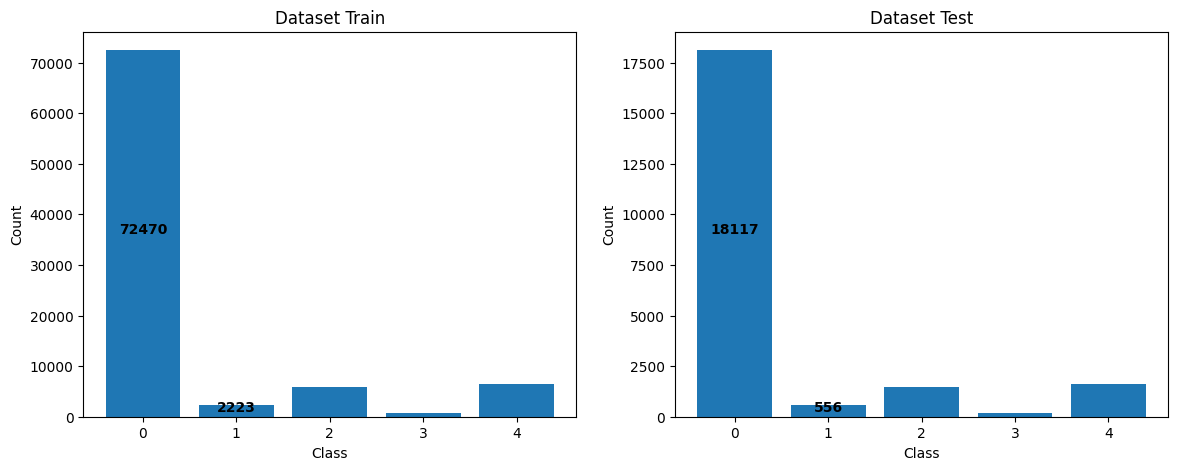

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(np.unique(y_train), datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0] / 2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1] / 2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
plt.show()


## Data preparation

In [4]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [5]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [6]:
X_train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=100,
                                shuffle=True)
X_test_dataloader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=100,
                               shuffle=False)

## Supervised Model for Transfer

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x += residual
        x = self.relu(x)
        return x
    
class ResidualCNNModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim):
        super(ResidualCNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.residual_block1 = ResidualBlock(16, 16, 3, 1, 1)
        self.residual_block2 = ResidualBlock(16, 16, 3, 1, 1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc_encoder = nn.LazyLinear(hidden_dim)
        self.relu = nn.ReLU()
        
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.max_pool2 = nn.MaxPool1d(kernel_size=3, stride=2)

        self.fc_out = nn.Linear(hidden_dim, output_size)
        
    def encode(self, x):
        x = torch.squeeze(x, dim=-1)
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.max_pool1(x)
        x = self.relu(x)
        x = self.residual_block1(x)
        x = self.residual_block2(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc_encoder(x)
        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.fc_out(x)
        return x
    
input_size = X_train_tensor.shape[1]
output_size = len(np.unique(y_train))
hidden_dim = 128

In [8]:
def train_model(model, model_name, criterion, optimizer, X_train_dataloader, X_test_tensor, y_test_tensor, num_epochs, truncate, ret_weights=False):
    epoch_losses_training = []
    epoch_losses_testing = []
    epoch_accuracies_training = []
    epoch_accuracies_testing = []

    best_test_accuracy = 0

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0
        pred_train = []
        y_train_list = []

        for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]

            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            
        
            pred_train.append(torch.argmax(outputs, dim=1))
            y_train_list.append(y_batch)

            total_loss += loss.item() * len(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_accuracies_training.append(
            balanced_accuracy_score(torch.cat(y_train_list).cpu().numpy(), torch.cat(pred_train).cpu().numpy()))
        epoch_losses_training.append(total_loss / len(X_train_tensor))

        with torch.no_grad():

            pred_test = []
            y_test_list = []

            for i, (X_batch, y_batch) in enumerate(X_test_dataloader):

                if ret_weights:
                    outputs, _ = model(X_batch)
                else:
                    outputs = model(X_batch)

                loss = criterion(outputs, y_batch)
                pred_test.append(torch.argmax(outputs, dim=1))
                y_test_list.append(y_batch)

                total_loss += loss.item() * len(X_batch)

            epoch_accuracies_testing.append(balanced_accuracy_score(torch.cat(y_test_list).cpu().numpy(), torch.cat(pred_test).cpu().numpy()))
            epoch_losses_testing.append(total_loss / len(X_test_tensor))

            pbar.set_description(
                f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, Test Loss: {epoch_losses_testing[-1]:.4f}, Test Balanced Accuracy: {epoch_accuracies_testing[-1]:.4f}')

            if epoch_accuracies_testing[-1] > best_test_accuracy:
                best_test_accuracy = epoch_accuracies_testing[-1]
                torch.save(model.state_dict(), f'./p2/models/{model_name}_{num_epochs}_best.pth')

            with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
                pickle.dump(
                    (epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing),
                    f)
    torch.save(model.state_dict(), f'./p2/models/{model_name}_{num_epochs}_final.pth')

In [9]:
def plot_acc_and_loss(model_name, num_epochs):
    with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', "rb") as f:
        while True:
            try:
                epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing = pickle.load(
                    f)
            except EOFError:
                break

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plotting the losses
    axs[0].plot(epoch_losses_training, label='Training Loss')
    axs[0].plot(epoch_losses_testing, label='Testing Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting the accuracies
    axs[1].plot(epoch_accuracies_training, label='Training Balanced Accuracy')
    axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [15]:
def print_model_summary(model, criterion, X_test_dataloader, ret_weights=False):
    print(model)
    print('Number of parameters: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

    with torch.no_grad():
        acc_test = []
        test_outputs = []
        total_loss_test = 0
        for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            pred = torch.argmax(outputs, dim=1)
            acc_test.append(pred == y_batch)
            test_outputs.append(pred)

            total_loss_test += loss.item() * len(X_batch)

    print(
        f'Accuracy: {torch.cat(acc_test).cpu().float().mean():.4f}, Balanced Accuracy: {balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), torch.cat(test_outputs).cpu().numpy()):.4f}, Loss: {total_loss_test / len(X_test_tensor)}, ')

In [11]:
res_cnn = ResidualCNNModel(input_size, output_size, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_cnn.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
num_epochs = 100
model_name = 'res_cnn_mit'
train_model(res_cnn, model_name, criterion, optimizer, X_train_dataloader, X_test_tensor, y_test_tensor,
            num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [100/100], Loss: 0.0235, Balanced Accuracy: 0.9463, Test Loss: 0.2072, Test Balanced Accuracy: 0.8816: 100%|██████████| 100/100 [18:57<00:00, 11.38s/it]


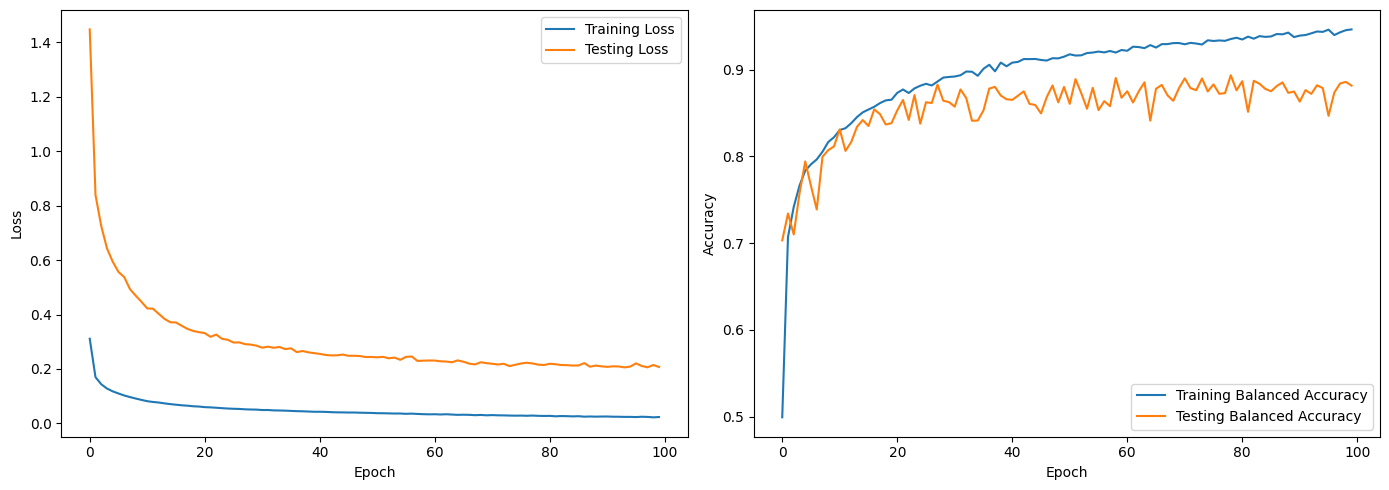

In [13]:
plot_acc_and_loss("res_cnn_mit", num_epochs)

In [16]:
res_cnn.load_state_dict(torch.load(f'./p2/models/{model_name}_{num_epochs}_final.pth'))
print_model_summary(res_cnn, criterion, X_test_dataloader)

ResidualCNNModel(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (residual_block1): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
  )
  (residual_block2): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): ReLU()
  )
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc_encoder): Linear(in_features=1472, out_features=128, bias=True)
  (relu): ReLU()
  (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_out): Linear(in_features=128, out_features=5, bias=True)
)
Number of parameters: 193957
Accuracy: 0.9806, Balanced Accuracy: 0.8816, Loss: 0.11337788318618477

## Representation Learning Model

In [10]:
class AutoEncoder(nn.Module):

    def __init__(self, input_size, latent_dim):
        super(AutoEncoder, self).__init__()

        self.cnn_out_channels = 32
        
        # encoder
        self.conv1_enc = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.residual_block1_enc = ResidualBlock(16, 16, 3, 1, 1)
        self.residual_block2_enc = ResidualBlock(16, 16, 3, 1, 1)
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.max_pool2 = nn.MaxPool1d(kernel_size=3, stride=2)
        self.conv2_enc = nn.Conv1d(in_channels=16, out_channels=self.cnn_out_channels, kernel_size=3, stride=1, padding=1)
        self.fc_encoder_enc = nn.LazyLinear(latent_dim)
        self.relu = nn.ReLU()

        
        
        # decoder
        self.conv1_dec = nn.Conv1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.residual_block1_dec = ResidualBlock(16, 16, 3, 1, 1)
        self.residual_block2_dec = ResidualBlock(16, 16, 3, 1, 1)
        self.conv2_dec = nn.Conv1d(in_channels=self.cnn_out_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        # This weird number is hardcoded because it comes from some padding/stride calculations
        self.fc_encoder_dec = nn.LazyLinear(hidden_dim * 92)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.upsample2 = nn.Upsample(input_size)
        
        # loss 
        self.mse = nn.MSELoss()

    def encode(self,x):
        x = self.conv1_enc(x.permute(0,2,1))
        x = self.max_pool1(x)
        x = self.relu(x)
        x = self.residual_block1_enc(x)
        x = self.residual_block2_enc(x)
        x = self.conv2_enc(x)
        x = self.max_pool2(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc_encoder_enc(x)
        return x
    
    def decode(self,z):
        x = self.fc_encoder_dec(z)
        x = x.view(x.size(0), 32, -1)
        x = self.upsample1(x)
        x = self.conv2_dec(x)
        x = self.residual_block2_dec(x)
        x = self.residual_block1_dec(x)
        x = self.upsample2(x)
        x = self.conv1_dec(x)

        return x.permute(0,2,1)
    
    def forward(self,x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
            
        return x_reconstructed

In [17]:
model_name = 'autoencoder_mit'
input_size = X_train_tensor.shape[1]
hidden_dim = 16

auto_encoder = AutoEncoder(input_size, hidden_dim).to(device)
optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [18]:
num_epochs = 100

pbar = tqdm(range(num_epochs))
epoch_losses_training = []
best_loss = 0

for epoch in pbar:
    total_loss = 0
    pred_train = []
    y_train_list = []

    for i, (X_batch, _) in enumerate(X_train_dataloader):
        x_reconstructed = auto_encoder(X_batch)

        loss = criterion(X_batch, x_reconstructed)
    
        total_loss += loss * len(X_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_losses_training.append(total_loss / len(X_train_tensor))

    with torch.no_grad():
        pbar.set_description(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {epoch_losses_training[-1]:.4f}')
        
    if epoch_losses_training[-1] > best_loss:
        best_test_accuracy = epoch_losses_training[-1]
        torch.save(auto_encoder.state_dict(), f'./p2/models/{model_name}_{num_epochs}_best.pth')

    with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
        pickle.dump(epoch_losses_training,f)
        
torch.save(auto_encoder.state_dict(), f'./p2/models/{model_name}_{num_epochs}_final.pth')

Epoch [100/100], training loss: 0.0004: 100%|██████████| 100/100 [26:16<00:00, 15.77s/it]


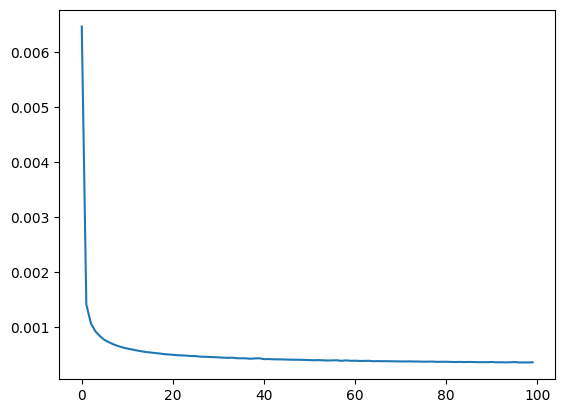

In [19]:
with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'rb') as f:
    epoch_losses_training = torch.stack(pickle.load(f)).detach().cpu().numpy()
 
plt.plot(epoch_losses_training, label='Training Loss')
plt.show()

In [20]:
#num_epochs = 10
auto_encoder.load_state_dict(torch.load(f'./p2/models/{model_name}_{num_epochs}_best.pth'))

<All keys matched successfully>

In [22]:
X_train_encoder_mit = []
y_train_encoder_mit = []

X_test_encoder_mit = []
y_test_encoder_mit = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs = auto_encoder.encode(X_batch)
        X_train_encoder_mit.append(outputs)
        y_train_encoder_mit.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs = auto_encoder.encode(X_batch)
        X_test_encoder_mit.append(outputs)
        y_test_encoder_mit.append(y_batch)

X_train_encoder_mit = torch.cat(X_train_encoder_mit).cpu().numpy().squeeze()
X_test_encoder_mit = torch.cat(X_test_encoder_mit).cpu().numpy().squeeze()

y_train_encoder_mit = torch.cat(y_train_encoder_mit).cpu().numpy().squeeze()
y_test_encoder_mit = torch.cat(y_test_encoder_mit).cpu().numpy().squeeze()

In [23]:
classifier = RandomForestClassifier()
classifier.fit(X_train_encoder_mit, y_train_encoder_mit)
y_pred = classifier.predict(X_test_encoder_mit)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoder_mit, y_pred):.4f}')

Test set balanced accuracy: 0.7910


## Visualising Learned Representations

In [24]:
def visualize_umap(X_train_umap, y_train):

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for i in np.unique(y_train):
        ax.scatter(X_train_umap[y_train == i, 0], X_train_umap[y_train == i, 1], label=f'Class {i}')

### ResCNN from Q1

In [26]:
input_size = X_train_tensor.shape[1]
output_size = len(np.unique(y_train))
hidden_dim = 128

res_cnn = ResidualCNNModel(input_size, output_size, hidden_dim).to(device)
res_cnn.load_state_dict(torch.load('./p2/models/res_cnn_mit_100_best.pth'))

<All keys matched successfully>

#### MIT data

In [27]:
X_train_res_cnn_mit = []
y_train_res_cnn_mit = []

X_test_res_cnn_mit = []
y_test_res_cnn_mit = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs = res_cnn.encode(X_batch)
        X_train_res_cnn_mit.append(outputs)
        y_train_res_cnn_mit.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs = res_cnn.encode(X_batch)
        X_test_res_cnn_mit.append(outputs)
        y_test_res_cnn_mit.append(y_batch)

X_train_res_cnn_mit = torch.cat(X_train_res_cnn_mit).cpu().numpy()
X_test_res_cnn_mit = torch.cat(X_test_res_cnn_mit).cpu().numpy()

y_train_res_cnn_mit = torch.cat(y_train_res_cnn_mit).cpu().numpy()
y_test_res_cnn_mit = torch.cat(y_test_res_cnn_mit).cpu().numpy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


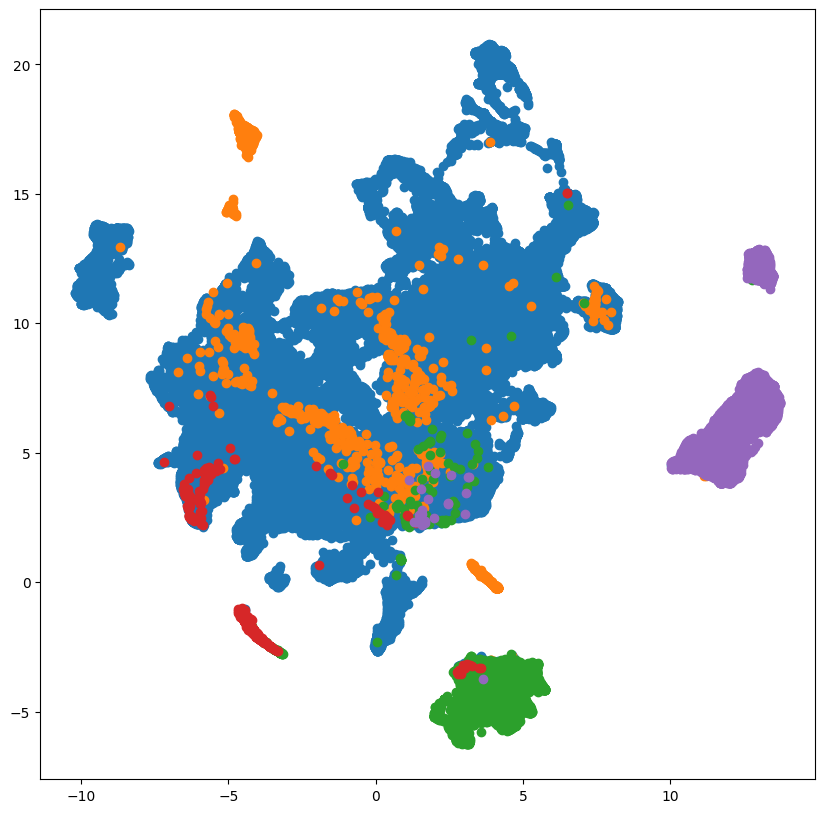

In [28]:
reducer = umap.UMAP(n_components=2)
X_train_umap = reducer.fit_transform(X_train_res_cnn_mit)
visualize_umap(X_train_umap, y_train_res_cnn_mit)

#### PTB data

In [29]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns) - 1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns) - 1)] + ['label']

X_train_ptb = data_train.iloc[:, :-1]
y_train_ptb = data_train.iloc[:, -1]
X_test_ptb = data_test.iloc[:, :-1]
y_test_ptb = data_test.iloc[:, -1]

X_train_tensor_ptb = torch.tensor(X_train_ptb.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor_ptb = torch.tensor(y_train_ptb.values, dtype=torch.float32).to(device)
X_test_tensor_ptb = torch.tensor(X_test_ptb.values, dtype=torch.float32).unsqueeze(2).to(device)
y_test_tensor_ptb = torch.tensor(y_test_ptb.values, dtype=torch.float32).to(device)

X_train_dataloader_ptb = DataLoader(torch.utils.data.TensorDataset(X_train_tensor_ptb, y_train_tensor_ptb),
                                    batch_size=100, shuffle=True)
X_test_dataloader_ptb = DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=100,
                                   shuffle=False)

In [30]:
X_train_res_cnn_ptb = []
y_train_res_cnn_ptb = []
X_test_res_cnn_ptb = []
y_test_res_cnn_ptb = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader_ptb):
        outputs = res_cnn.encode(X_batch)
        X_train_res_cnn_ptb.append(outputs)
        y_train_res_cnn_ptb.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader_ptb):
        outputs = res_cnn.encode(X_batch)
        X_test_res_cnn_ptb.append(outputs)
        y_test_res_cnn_ptb.append(y_batch)

X_train_res_cnn_ptb = torch.cat(X_train_res_cnn_ptb).cpu().numpy()
X_test_res_cnn_ptb = torch.cat(X_test_res_cnn_ptb).cpu().numpy()

y_train_res_cnn_ptb = torch.cat(y_train_res_cnn_ptb).cpu().numpy()
y_test_res_cnn_ptb = torch.cat(y_test_res_cnn_ptb).cpu().numpy()

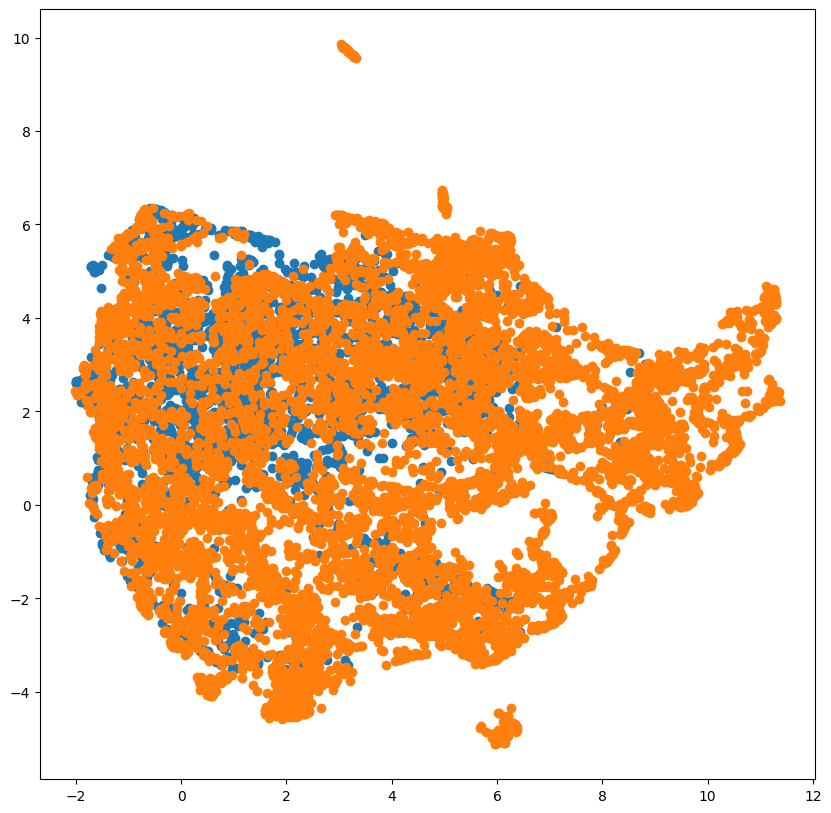

In [31]:
reducer = umap.UMAP(n_components=2)
X_train_umap = reducer.fit_transform(X_train_res_cnn_ptb)
visualize_umap(X_train_umap, y_train_res_cnn_ptb)

### Encoder

In [32]:
auto_encoder = AutoEncoder(input_size, hidden_dim).to(device)
auto_encoder.load_state_dict(torch.load('./p2/models/autoencoder_mit_100_best.pth'))

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

#### MIT data

In [33]:
X_train_encoder_mit = []
y_train_encoder_mit = []

X_test_encoder_mit = []
y_test_encoder_mit = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs = auto_encoder.encode(X_batch)
        X_train_encoder_mit.append(outputs)
        y_train_encoder_mit.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs = auto_encoder.encode(X_batch)
        X_test_encoder_mit.append(outputs)
        y_test_encoder_mit.append(y_batch)

X_train_encoder_mit = torch.cat(X_train_encoder_mit).cpu().numpy().squeeze()
X_test_encoder_mit = torch.cat(X_test_encoder_mit).cpu().numpy().squeeze()

y_train_encoder_mit = torch.cat(y_train_encoder_mit).cpu().numpy().squeeze()
y_test_encoder_mit = torch.cat(y_test_encoder_mit).cpu().numpy().squeeze()

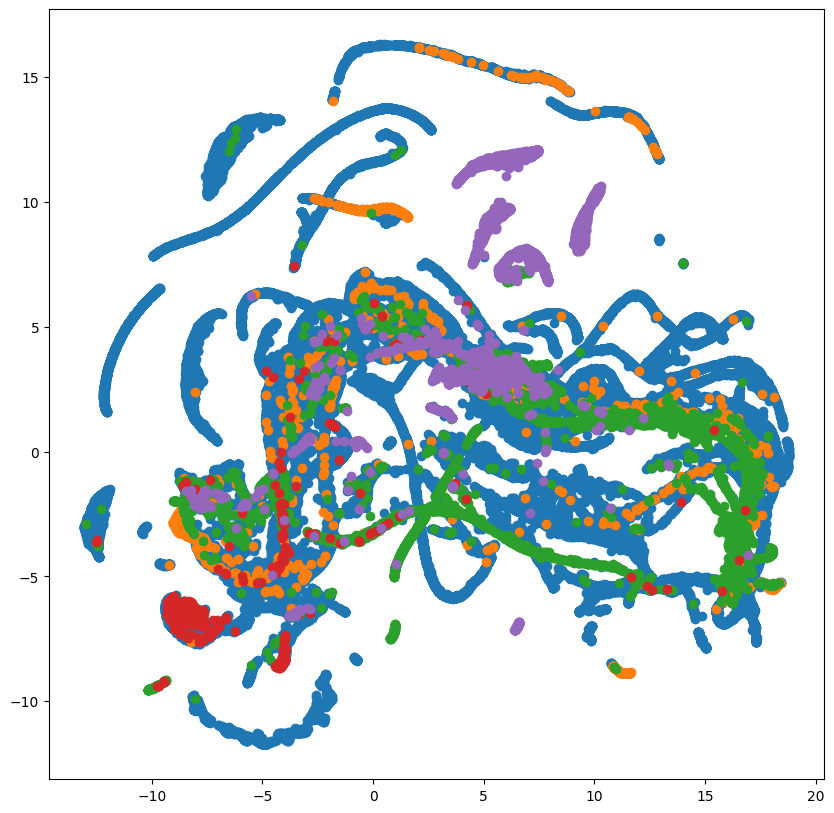

In [34]:
umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoder_mit)

visualize_umap(X_train_umap, y_train_encoder_mit)

#### PTB data

In [35]:
X_train_encoder_ptb = []
y_train_encoder_ptb = []
X_test_encoder_ptb = []
y_test_encoder_ptb = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader_ptb):
        outputs = auto_encoder.encode(X_batch)
        X_train_encoder_ptb.append(outputs)
        y_train_encoder_ptb.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader_ptb):
        outputs = auto_encoder.encode(X_batch)
        X_test_encoder_ptb.append(outputs)
        y_test_encoder_ptb.append(y_batch)

X_train_encoder_ptb = torch.cat(X_train_encoder_ptb).cpu().numpy().squeeze()
X_test_encoder_ptb = torch.cat(X_test_encoder_ptb).cpu().numpy().squeeze()

y_train_encoder_ptb = torch.cat(y_train_encoder_ptb).cpu().numpy().squeeze()
y_test_encoder_ptb = torch.cat(y_test_encoder_ptb).cpu().numpy().squeeze()

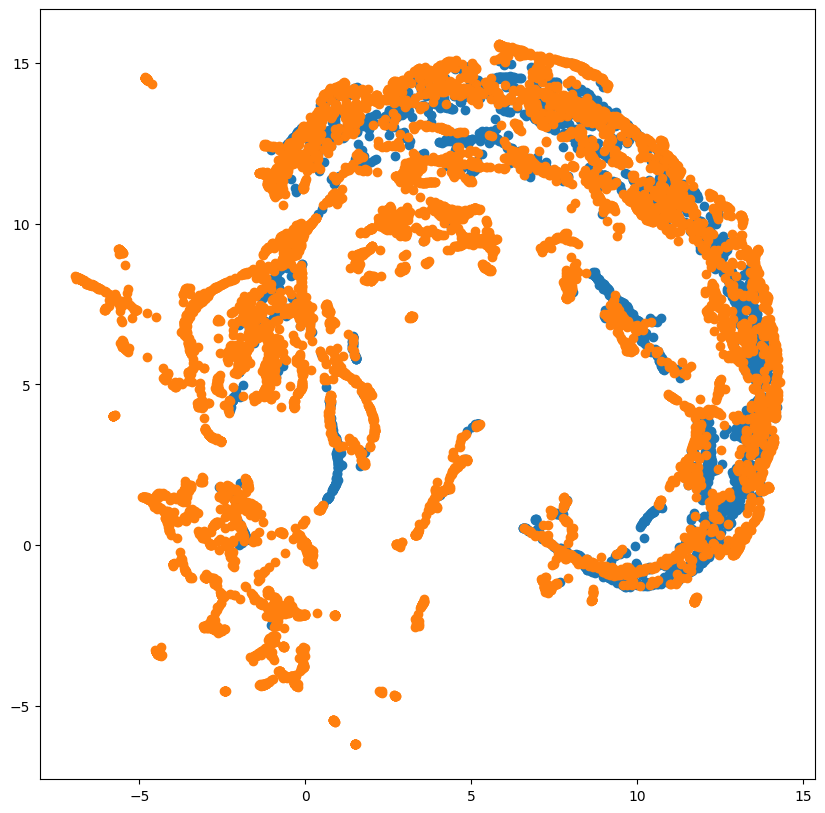

In [36]:
umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoder_ptb)

visualize_umap(X_train_umap, y_train_encoder_ptb)

## Finetuning Strategies

### Classic ML method

#### ResCNN

In [37]:
classifier = RandomForestClassifier()
classifier.fit(X_train_res_cnn_ptb, y_train_res_cnn_ptb)
y_pred = classifier.predict(X_test_res_cnn_ptb)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_res_cnn_ptb, y_pred):.4f}')

Test set balanced accuracy: 0.8303


#### Encoder

In [38]:
classifier = RandomForestClassifier()
classifier.fit(X_train_encoder_ptb, y_train_encoder_ptb)
y_pred = classifier.predict(X_test_encoder_ptb)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoder_ptb, y_pred):.4f}')

Test set balanced accuracy: 0.9180


### MLP output layers

In [39]:
def train_model(model, model_name, criterion, optimizer, X_train_dataloader, X_test_tensor, y_test_tensor, num_epochs, truncate, ret_weights=False):
    epoch_losses_training = []
    epoch_losses_testing = []
    epoch_accuracies_training = []
    epoch_accuracies_testing = []
    
    best_test_accuracy = 0

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0
        acc = []

        for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]
            
            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)
                
            loss = criterion(outputs, y_batch)
            acc.append((outputs > 0.5).int() == y_batch)

            total_loss += loss.item() * len(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        epoch_accuracies_training.append(torch.cat(acc).cpu().float().mean())
        epoch_losses_training.append(total_loss/len(X_train_tensor))

        with torch.no_grad():
            if ret_weights:
                output_test, _ = model(X_test_tensor)
            else:
                output_test = model(X_test_tensor)
                
            loss_test = criterion(output_test, y_test_tensor)
            epoch_losses_testing.append(loss_test.item())

            test_outputs = (output_test > 0.5).int()
            epoch_accuracies_testing.append(balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), test_outputs.cpu().numpy()))

            pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, Test Loss: {epoch_losses_testing[-1]:.4f}, Test Balanced Accuracy: {epoch_accuracies_testing[-1]:.4f}')
            
        if epoch_accuracies_testing[-1] > best_test_accuracy:
            best_test_accuracy = epoch_accuracies_testing[-1]
            torch.save(model.state_dict(), f'./p2/models/{model_name}_{num_epochs}.pth')
        
        with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
            pickle.dump((epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing), f)

In [40]:
def plot_acc_and_loss(model_name, num_epochs, plot=True):
    
    with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', "rb") as f:
        while True:
            try:
                epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing = pickle.load(f)
            except EOFError:
                break
    
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
        # Plotting the losses
        axs[0].plot(epoch_losses_training, label='Training Loss')
        axs[0].plot(epoch_losses_testing, label='Testing Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        
        # Plotting the accuracies
        axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
        axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        
        plt.tight_layout()
        plt.show()

In [45]:
def print_model_summary(model, criterion, X_test_tensor, y_test_tensor, ret_weights=False):
    print(model)
    print('Number of parameters: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    with torch.no_grad():
        if ret_weights:
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}, Balanced Accuracy: {balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), outputs.cpu().numpy())}')

In [46]:
class FinetunedModel(nn.Module):
    def __init__(self, encoder, hidden_dim = 128):
        super(FinetunedModel, self).__init__()
        self.encoder = encoder
        self.fc1 = nn.LazyLinear(hidden_dim)
        self.relu = nn.ReLU()
        self.fc_out = nn.LazyLinear(1)

    def forward(self, x):
        output = self.encoder.encode(x)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc_out(output)
        return output.squeeze()

#### Training of output layer only

##### ResCNN

In [53]:

input_size = X_train_tensor.shape[1]
output_size = len(np.unique(y_train))
hidden_dim = 128

pretrained_res_cnn = ResidualCNNModel(input_size, output_size, hidden_dim)
pretrained_res_cnn.load_state_dict(torch.load('./p2/models/res_cnn_mit_100_best.pth'))

finetuned_model_res_cnn_1 = FinetunedModel(pretrained_res_cnn).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_res_cnn_1.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [54]:
num_epochs = 100

for name, param in finetuned_model_res_cnn_1.named_parameters():
    if 'fc_out' not in name:
        param.requires_grad = False

model_name = 'finetuned_model_res_cnn_1'
train_model(finetuned_model_res_cnn_1, model_name, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [100/100], Loss: 0.0541, Balanced Accuracy: 0.8035, Test Loss: 0.4083, Test Balanced Accuracy: 0.7645: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


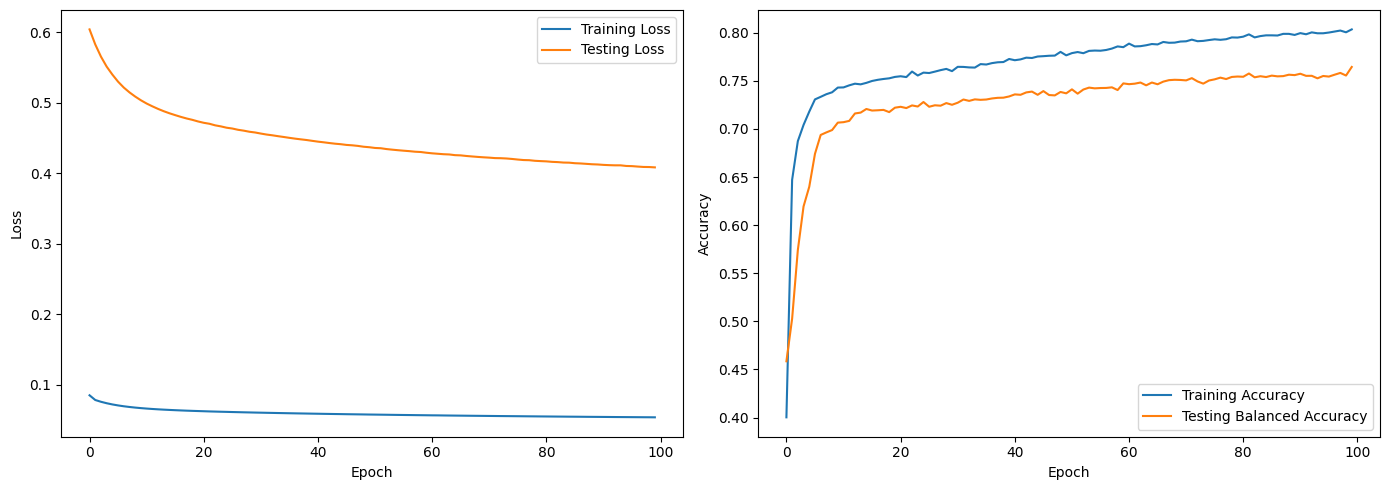

In [55]:
plot_acc_and_loss(model_name, num_epochs)

In [58]:
print_model_summary(finetuned_model_res_cnn_1, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): ResidualCNNModel(
    (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_block1): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (residual_block2): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_encoder): Linear(in_features=0, out_features=128, bias=True)
    (relu): ReLU()
    (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_out): Linear(in_features=128, out_features=5, bias=True)
  )
  (fc1): Linear(in_features=128, out_

##### Encoder

In [61]:
input_size = X_train_tensor.shape[1]
hidden_dim = 16

pretrained_autoencoder = AutoEncoder(input_size, hidden_dim)
pretrained_autoencoder.load_state_dict(torch.load('./p2/models/autoencoder_mit_100_best.pth'))

finetuned_model_encoder_1 = FinetunedModel(pretrained_autoencoder).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_encoder_1.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [63]:
num_epochs = 100

for name, param in finetuned_model_encoder_1.named_parameters():
    if 'fc_out' not in name:
        param.requires_grad = False

model_name = 'finetuned_model_encoder_1'
train_model(finetuned_model_encoder_1, model_name, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [100/100], Loss: 0.0509, Balanced Accuracy: 0.8200, Test Loss: 0.3806, Test Balanced Accuracy: 0.8000: 100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


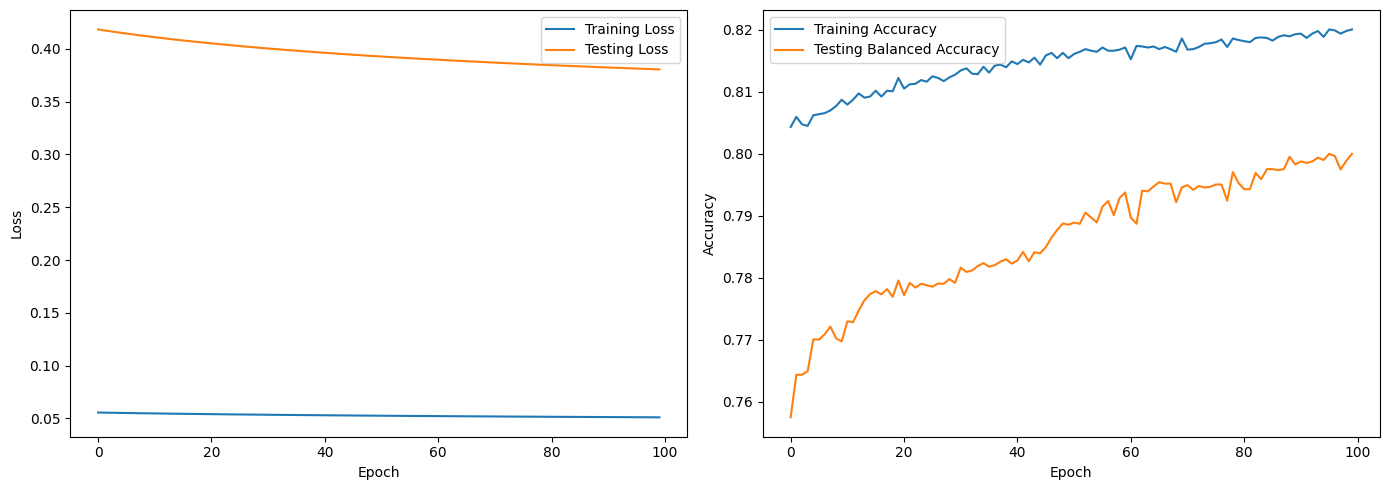

In [64]:
plot_acc_and_loss(model_name, num_epochs)

In [66]:
print_model_summary(finetuned_model_encoder_1, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): AutoEncoder(
    (conv1_enc): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_block1_enc): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (residual_block2_enc): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_enc): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_encoder_enc): Linear(in_features=0, out_features=16, bias=True)
    (relu): ReLU()
    (conv1_dec): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_bl

#### Training of entire model

##### ResCNN

In [69]:
pretrained_res_cnn.load_state_dict(torch.load('./p2/models/res_cnn_mit_100_best.pth'))

finetuned_model_res_cnn_2 = FinetunedModel(pretrained_res_cnn).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_res_cnn_2.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [70]:
num_epochs = 100
model_name = 'finetuned_model_res_cnn_2'
train_model(finetuned_model_res_cnn_2, model_name, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [100/100], Loss: 0.0295, Balanced Accuracy: 0.9049, Test Loss: 0.2557, Test Balanced Accuracy: 0.8747: 100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


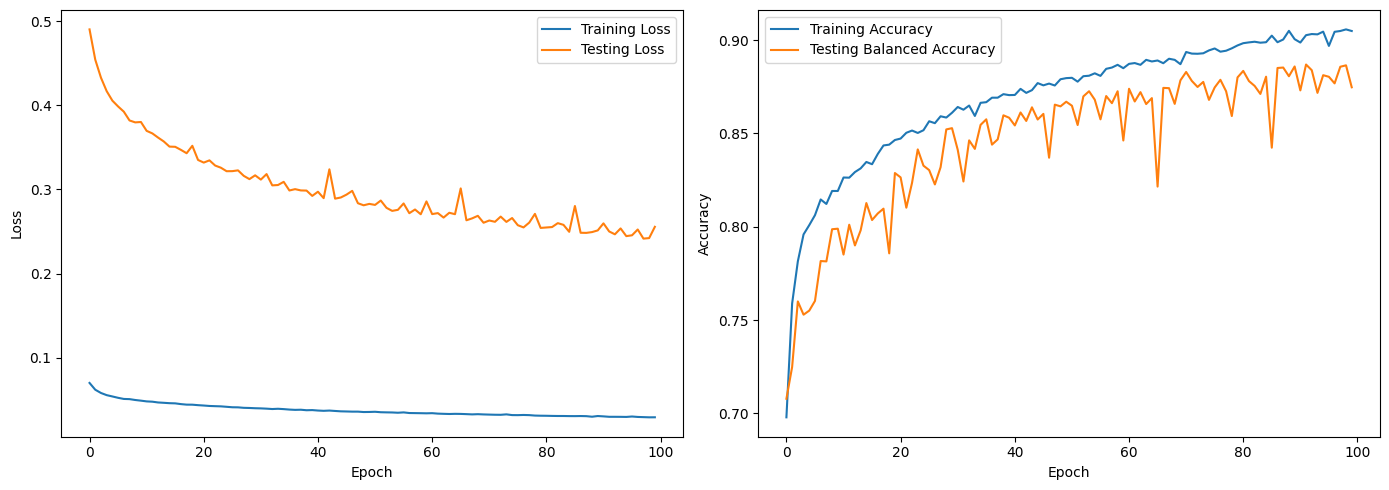

In [71]:
plot_acc_and_loss(model_name, num_epochs)

In [72]:
print_model_summary(finetuned_model_res_cnn_2, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): ResidualCNNModel(
    (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_block1): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (residual_block2): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_encoder): Linear(in_features=0, out_features=128, bias=True)
    (relu): ReLU()
    (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_out): Linear(in_features=128, out_features=5, bias=True)
  )
  (fc1): Linear(in_features=128, out_

##### AutoEncoder

In [73]:
pretrained_autoencoder.load_state_dict(torch.load('./p2/models/autoencoder_mit_100_best.pth'))

finetuned_model_encoder_2 = FinetunedModel(pretrained_autoencoder).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_encoder_2.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [74]:
num_epochs = 100
model_name = 'finetuned_model_encoder_2'
train_model(finetuned_model_encoder_2, model_name, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [100/100], Loss: 0.0259, Balanced Accuracy: 0.9193, Test Loss: 0.2104, Test Balanced Accuracy: 0.9140: 100%|██████████| 100/100 [01:20<00:00,  1.23it/s]


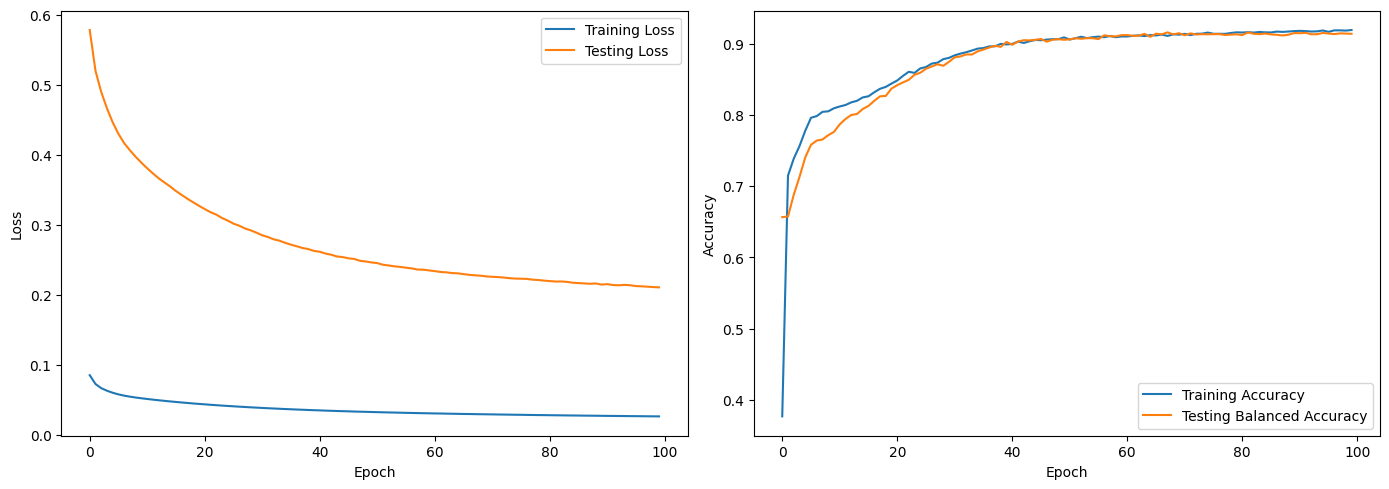

In [75]:
plot_acc_and_loss(model_name, num_epochs)

In [76]:
print_model_summary(finetuned_model_encoder_2, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): AutoEncoder(
    (conv1_enc): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_block1_enc): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (residual_block2_enc): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_enc): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_encoder_enc): Linear(in_features=0, out_features=16, bias=True)
    (relu): ReLU()
    (conv1_dec): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_bl

#### 2-stage training

##### ResCNN

In [77]:
pretrained_res_cnn.load_state_dict(torch.load('./p2/models/res_cnn_mit_100_best.pth'))

finetuned_model_res_cnn_3 = FinetunedModel(pretrained_res_cnn).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_res_cnn_3.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [78]:
num_epochs = 50

for name, param in finetuned_model_res_cnn_3.named_parameters():
    if 'fc_out' not in name:
        param.requires_grad = False

model_name_a = 'finetuned_model_res_cnn_3a'
train_model(finetuned_model_res_cnn_3, model_name_a, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

for name, param in finetuned_model_res_cnn_3.named_parameters():
    param.requires_grad = True
    
model_name_b = 'finetuned_model_res_cnn_3b'
train_model(finetuned_model_res_cnn_3, model_name_b, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [50/50], Loss: 0.0590, Balanced Accuracy: 0.7847, Test Loss: 0.4475, Test Balanced Accuracy: 0.7299: 100%|██████████| 50/50 [00:32<00:00,  1.52it/s]
Epoch [50/50], Loss: 0.0000, Balanced Accuracy: 1.0000, Test Loss: 0.0821, Test Balanced Accuracy: 0.9842: 100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


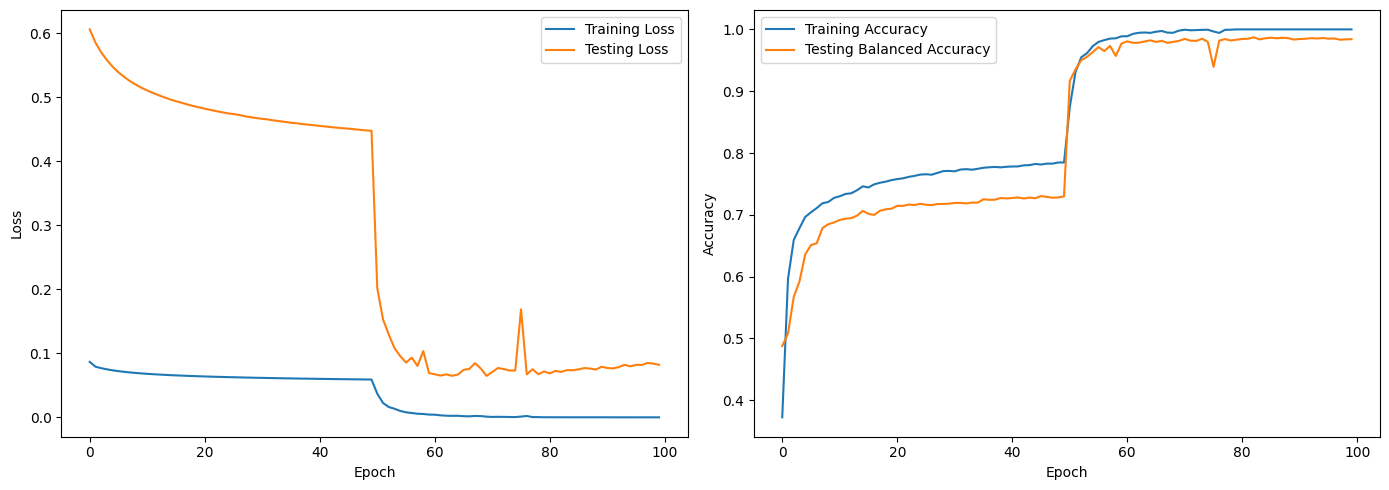

In [80]:
with open(f'./p2/eval/eval_{model_name_a}_{num_epochs}.pkl', "rb") as f:
    while True:
        try:
            epoch_losses_training_a, epoch_losses_testing_a, epoch_accuracies_training_a, epoch_accuracies_testing_a = pickle.load(f)
        except EOFError:
            break

with open(f'./p2/eval/eval_{model_name_b}_{num_epochs}.pkl', "rb") as f:
    while True:
        try:
            epoch_losses_training_b, epoch_losses_testing_b, epoch_accuracies_training_b, epoch_accuracies_testing_b = pickle.load(f)
        except EOFError:
            break
            
with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
            pickle.dump((epoch_losses_training_a + epoch_losses_training_b, epoch_losses_testing_a + epoch_losses_testing_b, epoch_accuracies_training_a + epoch_accuracies_training_b, epoch_accuracies_testing_a + epoch_accuracies_testing_b), f)

model_name = 'finetuned_model_res_cnn_3'
plot_acc_and_loss(model_name, num_epochs)

In [81]:
print_model_summary(finetuned_model_res_cnn_3, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): ResidualCNNModel(
    (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_block1): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (residual_block2): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_encoder): Linear(in_features=0, out_features=128, bias=True)
    (relu): ReLU()
    (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_out): Linear(in_features=128, out_features=5, bias=True)
  )
  (fc1): Linear(in_features=128, out_

##### AutoEncoder

In [82]:
pretrained_autoencoder.load_state_dict(torch.load('./p2/models/autoencoder_mit_100_best.pth'))

finetuned_model_cpc_3 = FinetunedModel(pretrained_autoencoder).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_cpc_3.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [83]:
num_epochs = 50

for name, param in finetuned_model_cpc_3.named_parameters():
    if 'fc_out' not in name:
        param.requires_grad = False

model_name_a = 'finetuned_model_cpc_3a'
train_model(finetuned_model_cpc_3, model_name_a, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

for name, param in finetuned_model_cpc_3.named_parameters():
    param.requires_grad = True
    
model_name_b = 'finetuned_model_cpc_3b'
train_model(finetuned_model_cpc_3, model_name_b, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [50/50], Loss: 0.0563, Balanced Accuracy: 0.7911, Test Loss: 0.4224, Test Balanced Accuracy: 0.7627: 100%|██████████| 50/50 [00:37<00:00,  1.32it/s]
Epoch [50/50], Loss: 0.0005, Balanced Accuracy: 0.9992, Test Loss: 0.0692, Test Balanced Accuracy: 0.9785: 100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


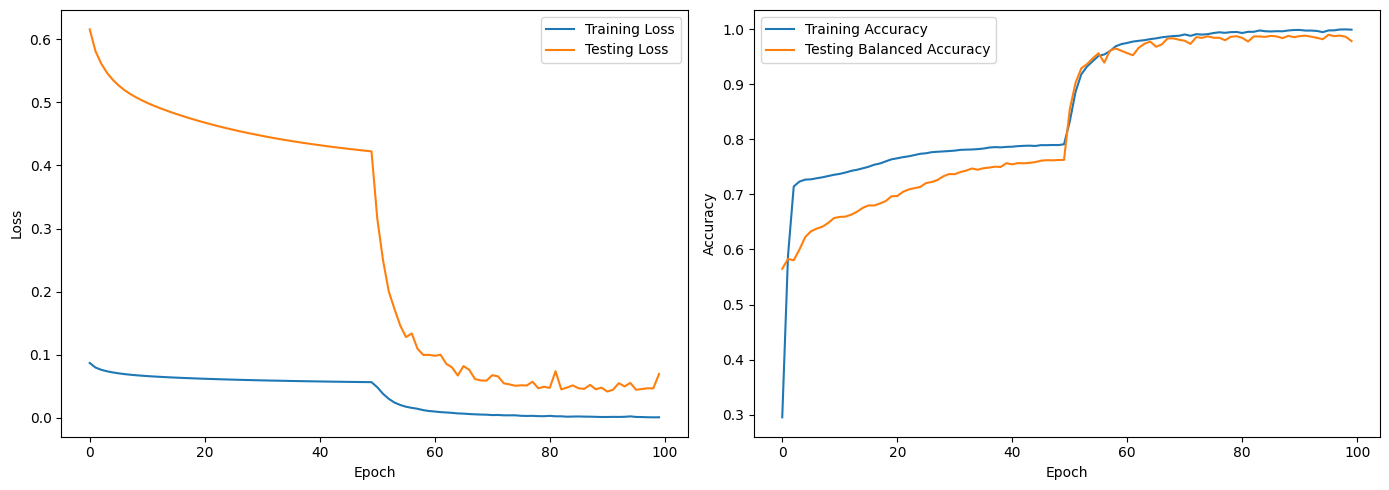

In [85]:
with open(f'./p2/eval/eval_{model_name_a}_{num_epochs}.pkl', "rb") as f:
    while True:
        try:
            epoch_losses_training_a, epoch_losses_testing_a, epoch_accuracies_training_a, epoch_accuracies_testing_a = pickle.load(f)
        except EOFError:
            break

with open(f'./p2/eval/eval_{model_name_b}_{num_epochs}.pkl', "rb") as f:
    while True:
        try:
            epoch_losses_training_b, epoch_losses_testing_b, epoch_accuracies_training_b, epoch_accuracies_testing_b = pickle.load(f)
        except EOFError:
            break
            
with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
            pickle.dump((epoch_losses_training_a + epoch_losses_training_b, epoch_losses_testing_a + epoch_losses_testing_b, epoch_accuracies_training_a + epoch_accuracies_training_b, epoch_accuracies_testing_a + epoch_accuracies_testing_b), f)

model_name = 'finetuned_model_cpc_3'
plot_acc_and_loss(model_name, num_epochs)

In [86]:
print_model_summary(finetuned_model_cpc_3, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): AutoEncoder(
    (conv1_enc): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_block1_enc): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (residual_block2_enc): ResidualBlock(
      (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (relu): ReLU()
    )
    (max_pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (max_pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_enc): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (fc_encoder_enc): Linear(in_features=0, out_features=16, bias=True)
    (relu): ReLU()
    (conv1_dec): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (residual_bl